##SchNet Architecture

**Tutorial en espanol basado en el libro "deep learning for molecules & materials" de Andrew D. White ([White, 2021](https://doi.org/10.33011/livecoms.3.1.1499).)**

** Se mantuvo las misma estructura de codigo para mostrar la similaridad entre problemas de clasificacion y regresion **

Recordando el paper de SchNet ([K. T. Schütt, 2018](https://doi.org/10.1063/1.5019779)) donde tienen un diagrama de bloques con la red neuronal.

En este notebook se calculara la energia U0 (Energia interna a 0K) haciendo uso del dataset QM9(ref) y la libreria SchnetPack(ref). Se mantiene el uso de Tensorflow para la programacion de la red, pero en este caso la red calculara un valor continuo a diferencia de una serie de probabilidades.

![Red GNN ([K. T. Schütt, 2018](https://doi.org/10.1063/1.5019779)](https://d3i71xaburhd42.cloudfront.net/5bf31dc4bd54b623008c13f8bc8954dc7c9a2d80/4-Figure2-1.png)



In [ ]:
!pip install schnetpack

## SchNet Example: Prediccion de energia


In [ ]:
import os
import schnetpack as spk
from schnetpack.datasets import QM9
import schnetpack.transform as trn
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import pandas as pd
import networkx as nx
import torch
import torchmetrics
import pytorch_lightning as pl

qm9tut = './qm9tut'
if not os.path.exists('qm9tut'):
    os.makedirs(qm9tut)

In [ ]:
#Importar datos QM9 dataset

%rm split.npz

qm9data = QM9(
    './qm9.db',
    batch_size=1,
    num_train=4000,
    num_val=1,
    num_test=1000,
    transforms=[
          trn.RemoveOffsets(QM9.U0, remove_mean=True, remove_atomrefs=True),
          trn.CastTo32()
     ],
    property_units={QM9.U0: 'kcal/mol'},
    num_workers=1,
    # split_file=os.path.join(qm9tut, "split.npz"),
    pin_memory=False, # set to false, when not using a GPU
    load_properties=[QM9.U0], #only load U0 property
)
#trn.RemoveOffsets(QM9.U0, remove_mean=True, remove_atomrefs=True)
qm9data.prepare_data()
qm9data.setup()

rm: cannot remove 'split.npz': No such file or directory


  0%|          | 0/4000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4000/4000 [00:47<00:00, 84.18it/s]


### Visualizacion de energias U0

Se muestra la distribucion de energia U0 previa normalizar la data

count    4000.000000
mean        8.880708
std        72.458435
min      -204.708054
25%       -35.687815
50%         9.959897
75%        58.462244
max       211.617371
Name: energy_U0, dtype: float64

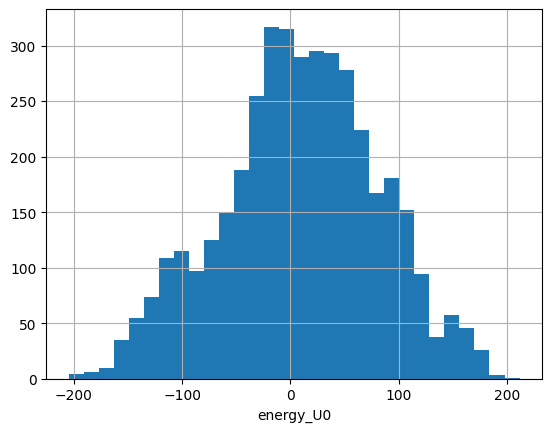

In [ ]:
# Statistics
energies = [dict_vals['energy_U0'].numpy()[0] for dict_vals in qm9data.train_dataset]
energies = pd.Series(energies, name=QM9.U0)
display(energies.describe())
ax = energies.hist(bins=30)
_ = ax.set_xlabel(QM9.U0)

def norm_energy(val):
  return (val-energies.mean())/energies.std()

def unnorm_energy(val):
  return val*energies.std()+energies.mean()

In [ ]:
qm9data.test_dataset.units #unidades dataset qm9

{'rotational_constant_A': 'GHz',
 'rotational_constant_B': 'GHz',
 'rotational_constant_C': 'GHz',
 'dipole_moment': 'Debye',
 'isotropic_polarizability': 'a0 a0 a0',
 'homo': 'Ha',
 'lumo': 'Ha',
 'gap': 'Ha',
 'electronic_spatial_extent': 'a0 a0',
 'zpve': 'Ha',
 'energy_U0': 'kcal/mol',
 'energy_U': 'Ha',
 'enthalpy_H': 'Ha',
 'free_energy': 'Ha',
 'heat_capacity': 'cal/mol/K'}

Se importan los datos hacia Tensorflow

In [ ]:
def generator():
  for dict_vals in qm9data.train_dataset:
      yield dict_vals['_positions'], dict_vals['_atomic_numbers'], norm_energy(dict_vals['energy_U0'].numpy())

def generator_test():
  for dict_vals in qm9data.test_dataset:
    yield dict_vals['_positions'], dict_vals['_atomic_numbers'], dict_vals['energy_U0'].numpy()

data = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(1), dtype=tf.float32)
    ),
).shuffle(4000, reshuffle_each_iteration=False,  # do not change order each time (!) otherwise will contaminate
)

test_data = tf.data.Dataset.from_generator(
    generator_test,
    output_signature=(
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(1), dtype=tf.float32)
    ),
).shuffle(1000, reshuffle_each_iteration=False,  # do not change order each time (!) otherwise will contaminate
)

train_data = data.take(3000)
val_data = data.skip(3000).take(1000)

Un grafico de algunas moleculas que se busca encontrar su energia U0

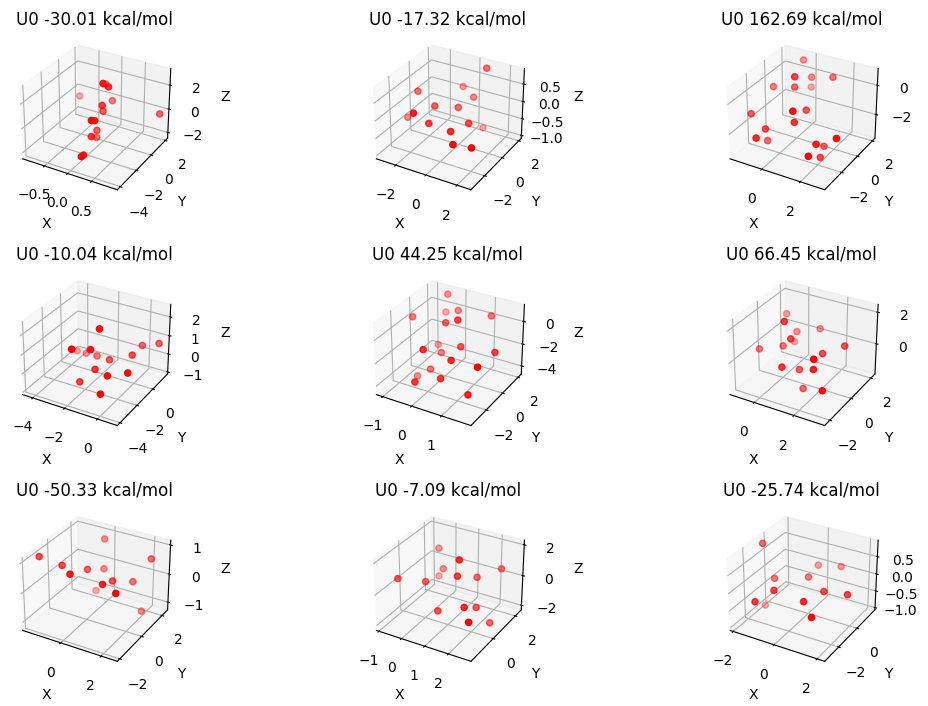

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8), subplot_kw={'projection': '3d'})
axs = axs.flatten()

# get a few examples and plot them
for i, (x, y, z) in enumerate(test_data):
    if i == 9:
        break
    # Graficar los puntos
    axs[i].scatter(x[:, 0], x[:, 1], x[:, 2], c='r',marker='o')
    num_title = np.around(z.numpy()[0],1)
    axs[i].set_title(f'U0 {round(float(z.numpy()[0]),2)} kcal/mol')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].set_zlabel('Z')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
plt.show()


### Building the graphs

Como se observa en los graficos, no necesariamente todos los atomos debiesen influir sobre todos, o al menos no de la misma forma, por lo que primero se construye una funcion que calcula la distancia de todos los atomos entre si, y calcula los NN atomos que tienen menor distancia con respecto a un atomo dado, esto sin considerar la distancia que tiene un atomo consigo mismo. La salida de esta funcion es:

*   **-topk.values** : tensor shape $(\cdot ,N)$, que posee las N distancias mas pequenas con respecto al atomo de la fila i
*   **topk.indices**: tensor shape $(\cdot ,N)$, que posee los N indices correspondientes a los atomos mas cercanos al de la fila i

In [ ]:
# this decorator speeds up the function by "compiling" it (tracing it)
# to run efficienty
@tf.function(
    reduce_retracing=True,
)
def get_edges(positions, NN, sorted=True):
    M = tf.shape(input=positions)[0] #number of points
    # adjust NN
    NN = tf.minimum(NN, M)
    qexpand = tf.expand_dims(positions, 1)  # add dim extra at 1
    qTexpand = tf.expand_dims(positions, 0)  # add dim extra at 0
    # repeat it to make matrix of all positions
    qtile = tf.tile(qexpand, [1, M, 1]) #repeat M times
    qTtile = tf.tile(qTexpand, [M, 1, 1])
    # subtract them to get distance matrix
    dist_mat = qTtile - qtile
    # mask distance matrix to remove zros (self-interactions)
    dist = tf.norm(tensor=dist_mat, axis=2)
    mask = dist >= 5e-4
    mask_cast = tf.cast(mask, dtype=dist.dtype) #matriz 0 y 1
    # make masked things be really far
    dist_mat_r = dist * mask_cast + (1 - mask_cast) * 1000
    topk = tf.math.top_k(-dist_mat_r, k=NN, sorted=sorted)
    return -topk.values, topk.indices

Se puede visualizar como define los N vecinos mas cercanos esta funcion

Con esto se puede agregar esta informacion al dataset, pero es deseable mas como se explico en un comienzo anadir mas features a estas distancia que se realizan por medio de la rbf
$$
e_k = \exp\left(-\gamma \left(r - \mu_k\right)^2\right)
$$ (rbf-edge)

Donde luego cambia unicamente la matriz de distancia a un tensor de orden 3 de distancia. Especificamente al modelo se le entrega como input

- **Valores nodales**, los cuales en este caso corresponde al elemento atomico que se asocia al atomo
- **Tensor de distancia** $D_{ij}$ donde para cada nodo $i$ con respecto a un nodo $j$, se tiene un vector de distancia dado por la longitud de $\mu_k$ (edge features). Notar que son los $j$ vecinos mas cercanos de nodo $i$
- **Tensor de vecinos cercanos**, para nodo $i$ se muestran los $N$ vecinos cercanos, dados por sus indices

In [ ]:
MAX_DEGREE = 10 #cantidad de vecinos a un atomo dado
EDGE_FEATURES = 300 #cantidad de caracteristicas por distancia
MAX_R = 30 #hiperparametro de rbf

gamma = 10
mu = np.linspace(0, MAX_R, EDGE_FEATURES)


def rbf(r):
    return tf.exp(-gamma * (r[..., tf.newaxis] - mu) ** 2)


def make_graph(x, y, z):
    edge_r, edge_i = get_edges(x, MAX_DEGREE)
    edge_features = rbf(edge_r)
    return (y, edge_features, edge_i), z

graph_train_data = train_data.map(make_graph)
graph_val_data = val_data.map(make_graph)
graph_test_data = test_data.map(make_graph)

In [ ]:
length_dataset = graph_val_data.reduce(0, lambda x,_: x+1).numpy()

In [ ]:
length_dataset

1000

Para agregar la nolinealidad se definen 3 capas de redes neuronales h1, h2 y h3, con una funcion de activacion shifted softplus

In [ ]:
def ssp(x):
    # shifted softplus activation
    return tf.math.log(0.5 * tf.math.exp(x) + 0.5)


def make_h1(units):
    return tf.keras.Sequential([tf.keras.layers.Dense(units)])


def make_h2(units):
    return tf.keras.Sequential(
        [
            tf.keras.layers.Dense(units, activation=ssp),
            tf.keras.layers.Dense(units, activation=ssp),
        ]
    )


def make_h3(units):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(units, activation=ssp), tf.keras.layers.Dense(units)]
    )


### Implementando las GNN

In [ ]:
class SchNetModel(tf.keras.Model):
    """Implementation of SchNet Model"""

    def __init__(self, gnn_blocks, channels, **kwargs):
        super(SchNetModel, self).__init__(**kwargs)
        self.gnn_blocks = gnn_blocks

        # build our layers
        self.embedding = tf.keras.layers.Embedding(20, channels) #transform to 1 to channels
        self.h1s = [make_h1(channels) for _ in range(self.gnn_blocks)]
        self.h2s = [make_h2(channels) for _ in range(self.gnn_blocks)]
        self.h3s = [make_h3(channels) for _ in range(self.gnn_blocks)]
        self.readout_l1 = tf.keras.layers.Dense(channels // 2, activation=ssp)
        self.readout_l2 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        nodes, edge_features, edge_i = inputs
        # turn node types as index to features
        nodes = self.embedding(nodes)
        for i in range(self.gnn_blocks):
            # get the node features per edge
            v_sk = tf.gather(nodes, edge_i) #choose closest atoms
            e_k = self.h1s[i](v_sk) * self.h2s[i](edge_features) #calculate directions of update atoms
            e_i = tf.reduce_sum(e_k, axis=1) #compute sum over all closest atoms
            nodes += self.h3s[i](e_i) #update node feature. The edge feature are not updated
        # readout now
        nodes = self.readout_l1(nodes)
        nodes = self.readout_l2(nodes)
        return tf.reduce_mean(nodes, axis=0) #invariant operation



In [ ]:
small_schnet = SchNetModel(3, 64) #3 capas 30 canales

### Entrenamiento

Queda unicamente entrenar el modelo!, se elige la metrica mae (Mean Absolute Error) para comparar luego con SchNet

In [ ]:
small_schnet.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-4), loss='mse', metrics=['mae']
)
# Train your model
result = small_schnet.fit(graph_train_data, validation_data=graph_val_data, epochs=50)

Epoch 1/50
3000/3000 [==============================] - 72s 18ms/step - loss: 0.3251 - mae: 0.4345 - val_loss: 0.2005 - val_mae: 0.3597
Epoch 2/50
3000/3000 [==============================] - 61s 17ms/step - loss: 0.1590 - mae: 0.3177 - val_loss: 0.1458 - val_mae: 0.3057
Epoch 3/50
3000/3000 [==============================] - 66s 17ms/step - loss: 0.1241 - mae: 0.2767 - val_loss: 0.0996 - val_mae: 0.2495
Epoch 4/50
3000/3000 [==============================] - 70s 19ms/step - loss: 0.1036 - mae: 0.2497 - val_loss: 0.0841 - val_mae: 0.2269
Epoch 5/50
3000/3000 [==============================] - 69s 19ms/step - loss: 0.0917 - mae: 0.2336 - val_loss: 0.0761 - val_mae: 0.2153
Epoch 6/50
3000/3000 [==============================] - 89s 26ms/step - loss: 0.0817 - mae: 0.2211 - val_loss: 0.0690 - val_mae: 0.2052
Epoch 7/50
3000/3000 [==============================] - 75s 21ms/step - loss: 0.0720 - mae: 0.2087 - val_loss: 0.0604 - val_mae: 0.1919
Epoch 8/50
3000/3000 [==========================

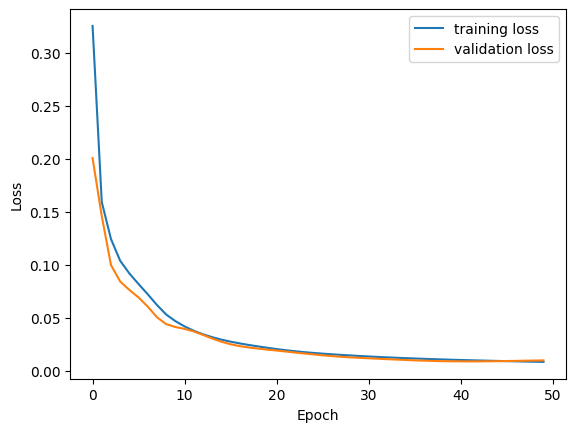

In [37]:
plt.plot(result.history["loss"], label="training loss")
plt.plot(result.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Luego se evalua en base al test set, considerando quitar la normalizacion hecha sobre los datos

In [38]:
mae = 0
for i, (x, y) in enumerate(graph_test_data):
    yhat = unnorm_energy(small_schnet(x))
    mae += abs(yhat[0] - y.numpy()[0])
print(f'MAE (Test set): {mae/(i+1)}')

MAE (Test set): 5.636819362640381


Como referencia MAE = 0.59 con 50k datos se reporta en el paper de Schnet(ref). Se grafica la estructura de los datos, la energia predicha y la prediccion hecha por la red

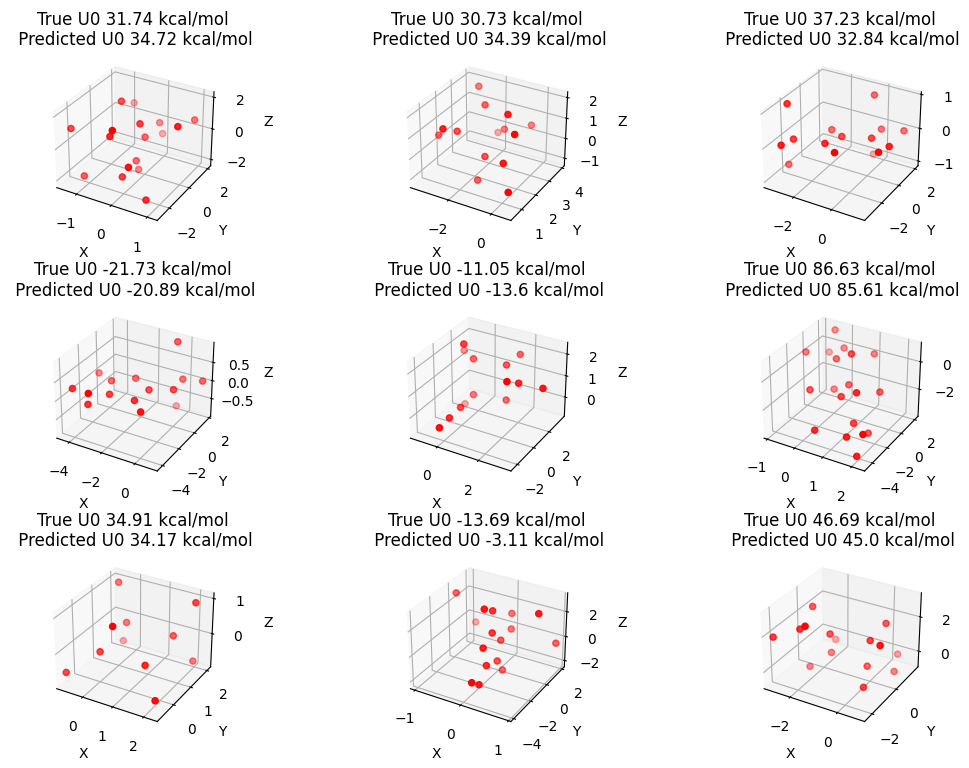

In [39]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8), subplot_kw={'projection': '3d'})
axs = axs.flatten()

# get a few examples and plot them
for i, (x, y, z) in enumerate(test_data):
    if i == 9:
        break
    # Graficar los puntos
    axs[i].scatter(x[:, 0], x[:, 1], x[:, 2], c='r',marker='o')
    num_title = np.around(z.numpy()[0],1)
    (xi), eta = make_graph(x, y, z)
    gnn_energy = unnorm_energy(small_schnet(xi))
    axs[i].set_title(f'True U0 {round(float(z.numpy()[0]),2)} kcal/mol\n Predicted U0 {round(float(gnn_energy[0]),2)} kcal/mol')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].set_zlabel('Z')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.05, wspace=0.4, hspace=0.4)
plt.show()

En este caso ocupamos U0 para poder comparar con Schnet, pero se puede probar otras cantidades continuos como la entalpia (H) o la energia libre (G)

  0%|          | 0/4000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████▉| 3999/4000 [00:50<00:00, 90.86it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4000/4000 [00:50<00:00, 78.53it/s]


count    4000.000000
mean        8.948400
std        71.805717
min      -202.025101
25%       -35.356492
50%        10.182527
75%        58.097341
max       213.328018
Name: free_energy, dtype: float64

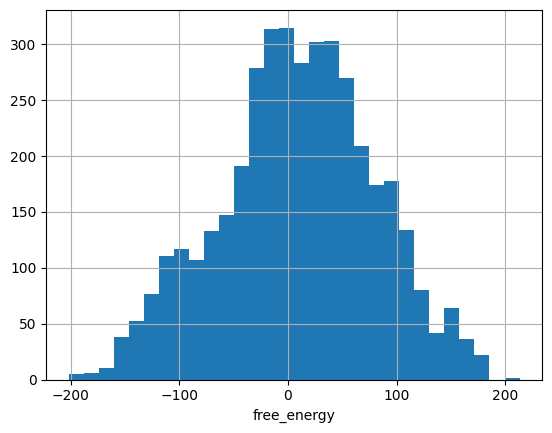

In [41]:
#importar el G

qm9data = QM9(
    './qm9.db',
    batch_size=1,
    num_train=4000,
    num_val=1,
    num_test=1000,
    transforms=[
          trn.RemoveOffsets(QM9.G, remove_mean=True, remove_atomrefs=True),
          trn.CastTo32()
     ],
    property_units={QM9.G: 'kcal/mol'},
    num_workers=1,
    # split_file=os.path.join(qm9tut, "split.npz"),
    pin_memory=False, # set to false, when not using a GPU
    load_properties=[QM9.G], #only load U0 property
)
#trn.RemoveOffsets(QM9.U0, remove_mean=True, remove_atomrefs=True)
qm9data.prepare_data()
qm9data.setup()


# Statistics
energies = [dict_vals['free_energy'].numpy()[0] for dict_vals in qm9data.train_dataset]
energies = pd.Series(energies, name=QM9.G)
display(energies.describe())
ax = energies.hist(bins=30)
_ = ax.set_xlabel(QM9.G)

def norm_energy(val):
  return (val-energies.mean())/energies.std()

def unnorm_energy(val):
  return val*energies.std()+energies.mean()

In [46]:
def generator():
  for dict_vals in qm9data.train_dataset:
      yield dict_vals['_positions'], dict_vals['_atomic_numbers'], norm_energy(dict_vals['free_energy'].numpy())

def generator_test():
  for dict_vals in qm9data.test_dataset:
    yield dict_vals['_positions'], dict_vals['_atomic_numbers'], dict_vals['free_energy'].numpy()

data = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(1), dtype=tf.float32)
    ),
).shuffle(4000, reshuffle_each_iteration=False,  # do not change order each time (!) otherwise will contaminate
)

test_data = tf.data.Dataset.from_generator(
    generator_test,
    output_signature=(
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(1), dtype=tf.float32)
    ),
).shuffle(1000, reshuffle_each_iteration=False,  # do not change order each time (!) otherwise will contaminate
)

train_data = data.take(3000)
val_data = data.skip(3000).take(1000)

graph_train_data = train_data.map(make_graph)
graph_val_data = val_data.map(make_graph)
graph_test_data = test_data.map(make_graph)

In [47]:
small_schnet = SchNetModel(3, 64) #3 capas 30 canales

In [48]:
small_schnet.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-4), loss='mse', metrics=['mae']
)
# Train your model
result = small_schnet.fit(graph_train_data, validation_data=graph_val_data, epochs=50)

Epoch 1/50
3000/3000 [==============================] - 68s 17ms/step - loss: 0.3015 - mae: 0.4189 - val_loss: 0.1740 - val_mae: 0.3364
Epoch 2/50
3000/3000 [==============================] - 59s 16ms/step - loss: 0.1645 - mae: 0.3232 - val_loss: 0.1336 - val_mae: 0.2935
Epoch 3/50
3000/3000 [==============================] - 60s 16ms/step - loss: 0.1313 - mae: 0.2868 - val_loss: 0.1088 - val_mae: 0.2615
Epoch 4/50
3000/3000 [==============================] - 59s 16ms/step - loss: 0.1075 - mae: 0.2581 - val_loss: 0.0960 - val_mae: 0.2447
Epoch 5/50
3000/3000 [==============================] - 65s 18ms/step - loss: 0.0924 - mae: 0.2385 - val_loss: 0.0854 - val_mae: 0.2310
Epoch 6/50
3000/3000 [==============================] - 59s 16ms/step - loss: 0.0808 - mae: 0.2224 - val_loss: 0.0764 - val_mae: 0.2197
Epoch 7/50
3000/3000 [==============================] - 58s 16ms/step - loss: 0.0707 - mae: 0.2076 - val_loss: 0.0689 - val_mae: 0.2095
Epoch 8/50
3000/3000 [==========================

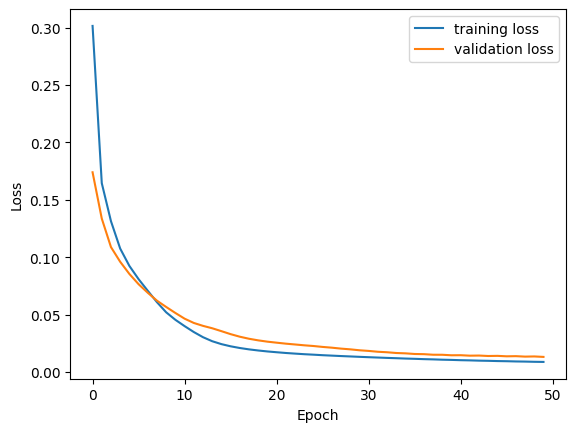

In [51]:
plt.plot(result.history["loss"], label="training loss")
plt.plot(result.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [49]:
mae = 0
for i, (x, y) in enumerate(graph_test_data):
    yhat = unnorm_energy(small_schnet(x))
    mae += abs(yhat[0] - y.numpy()[0])
print(f'MAE (Test set): {mae/(i+1)}')

MAE (Test set): 6.345767974853516


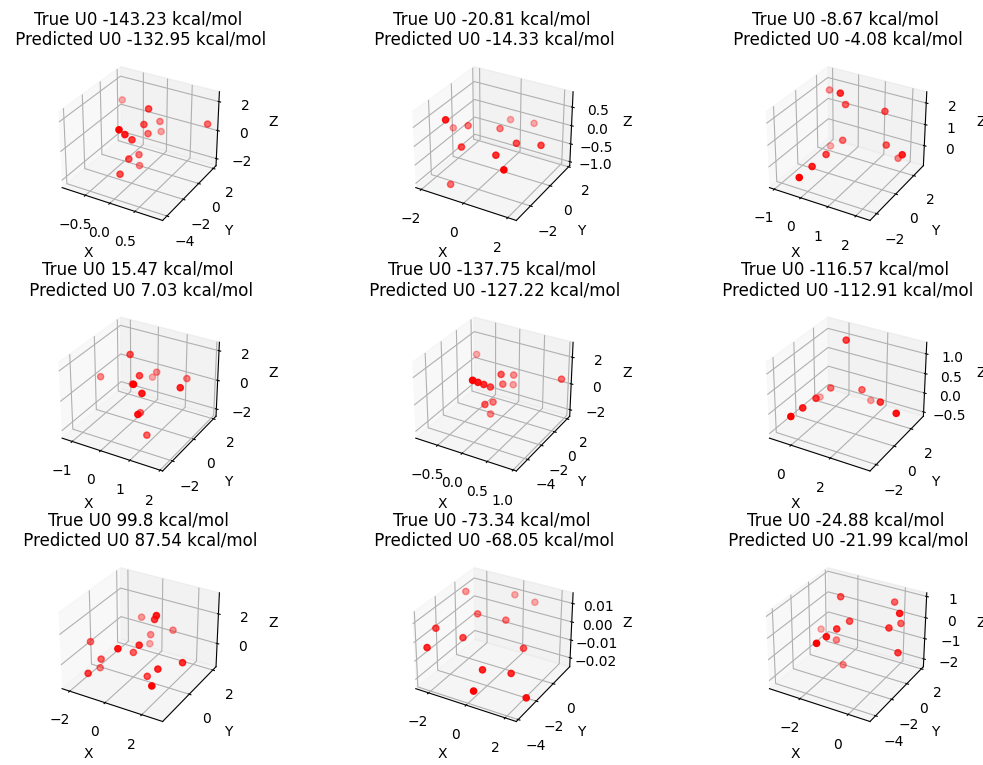

In [50]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8), subplot_kw={'projection': '3d'})
axs = axs.flatten()

# get a few examples and plot them
for i, (x, y, z) in enumerate(test_data):
    if i == 9:
        break
    # Graficar los puntos
    axs[i].scatter(x[:, 0], x[:, 1], x[:, 2], c='r',marker='o')
    num_title = np.around(z.numpy()[0],1)
    (xi), eta = make_graph(x, y, z)
    gnn_energy = unnorm_energy(small_schnet(xi))
    axs[i].set_title(f'True G {round(float(z.numpy()[0]),2)} kcal/mol\n Predicted G {round(float(gnn_energy[0]),2)} kcal/mol')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].set_zlabel('Z')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.05, wspace=0.4, hspace=0.4)